# **I- Collecting Data with Scrapy | Basic Spider & Web Crawler**

#### In this **first section**, I will explain (with words and code) the **two spiders** (one **basic spider** and one **web crawler**) that I developed to collect data on book reviews available on French websites. For this purpose, my spiders iterated several pages and subpages to create a complete dataset.

### **I-1 What is Scrapy and how can you create your first project?**

**Scrapy** is an **open framework** for extracting the data we need from websites.
Scrapy was created to build web spiders that can crawl the web on their own and save data. It is not a library but a whole framework that is enough by itself to build a robust web scraping project, while other web scraping tools are simple libraries that will often need to import additional libraries to achieve the scope of the Scrapy features.

**To Build your first dataset** with **Scrapy framework**, you need to:
- **Install Scrapy**: you have to write the following command in the terminal: **pip install scrapy** (or in the Anaconda's command prompt: **conda install scrapy**)
- **Start a Project** (still in the Terminal), you write: **scrapy startproject name_project**
- **Create a basic spider**: (still on the Terminal), you write: **scrapy genspider name_spider address_site_to_scrape**
- **Create a crawler**: (still in the terminal), you write: **scrapy genspider -t crawl name_crawler address_site_to_scrape**

**==> In this screenshot, I demonstrate how the Scrapy Project is launched using terminal commands mentioned above.**

![initializing Scrapy Project](attachment:81101322-91e1-4655-b2bd-b1d47e8dda6d.jpg)

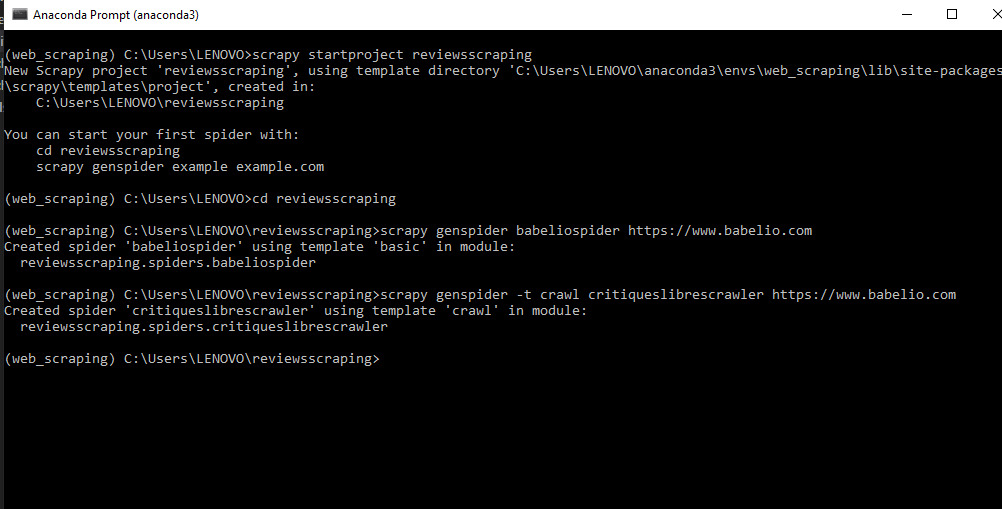

**Then, when opening the Scrapy project you've just created, you will see all these files added.**   
Scrapy has created every file needed for your scraper. **The structure is the following** :
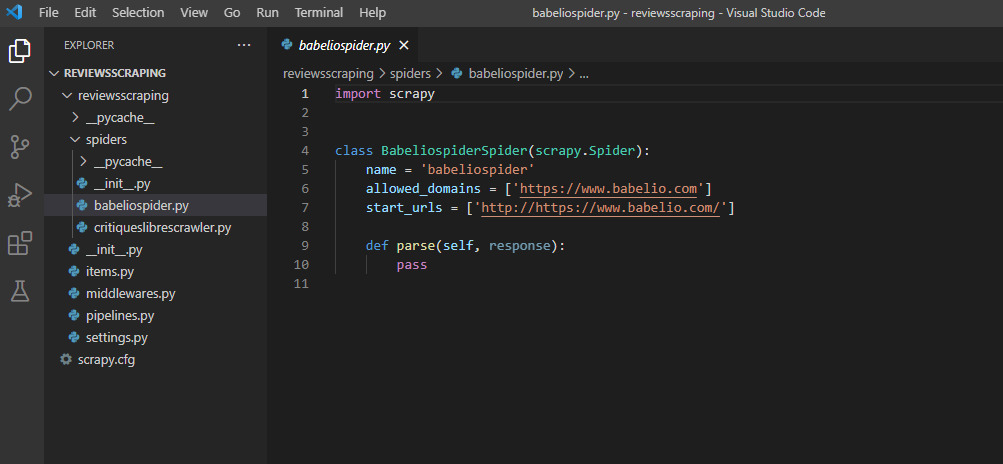

In fact, this **structure** mentioned above is illustrated by the **following diagram**, which you can find in the [scrapy documentation](https://docs.scrapy.org/en/latest/index.html)  
 
This link [scrapy Project components](https://docs.scrapy.org/en/latest/topics/architecture.html) provides a brief **Description** of the various components (of a Scrapy Project).

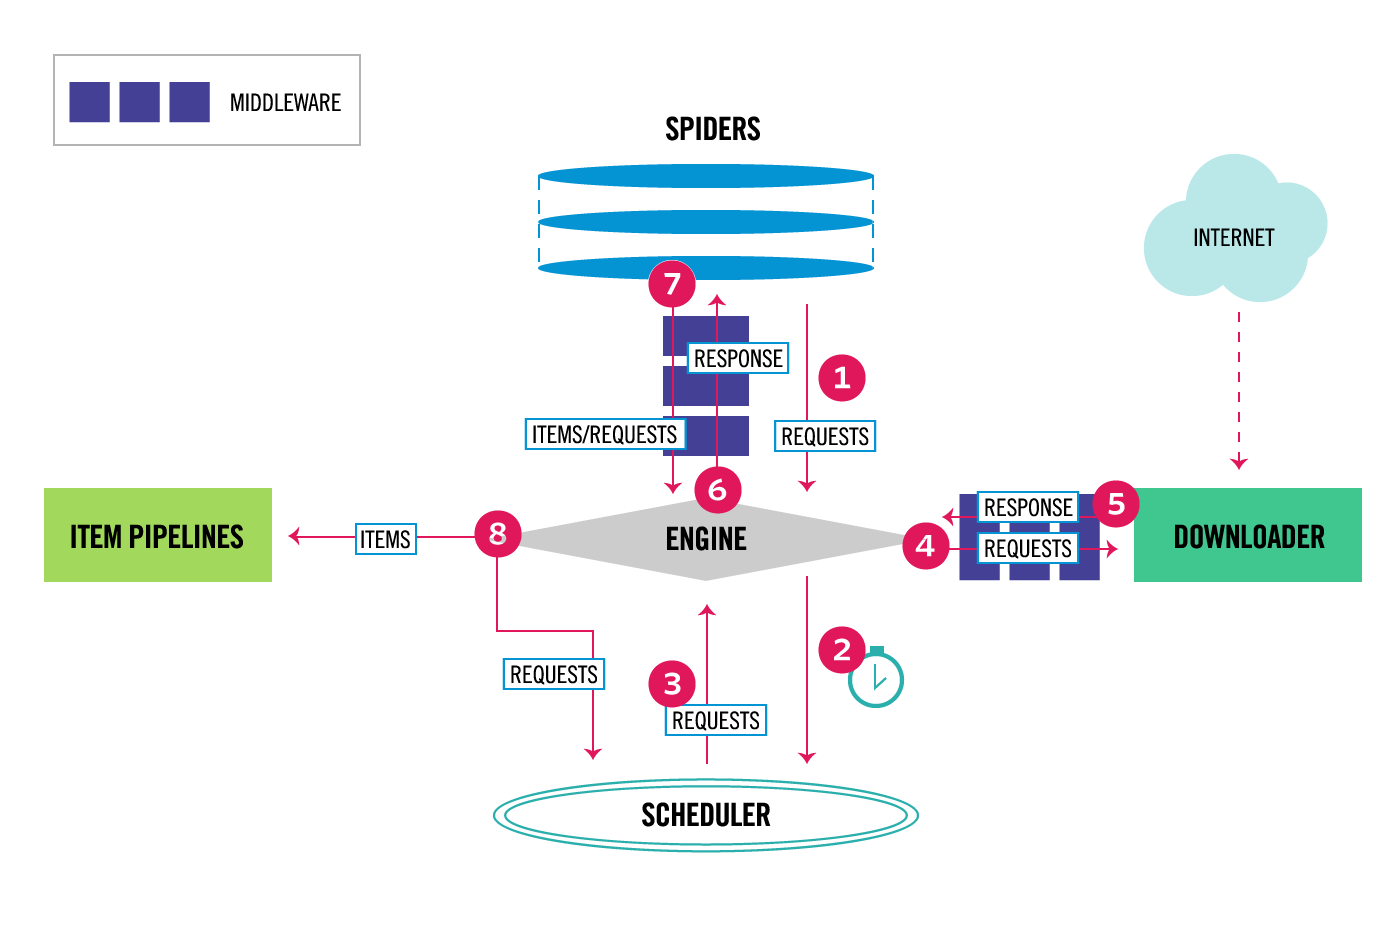

### **I-2 Building a Basic Spider to Scrape the 1st book reviews site**  


- The original source of data of the **first dataset** is the [Babelio](https://www.babelio.com/) site.

- **About Babelio**: is both a website and a mobile application dedicated to **French literature** and a **social network** intended to register personal libraries, which can then be shared and commented on by other users. The site operates on the principle of a social cataloging web application.

You find **all the Scrapy project files** attached to the notebook (in the data section). The **path of the folder** is: [Scrape_babelio](https://github.com/Abirate/Dataset_Creation_Scrapy_Project_French_book_reviews/tree/master/Scrape_Babelio_Site)
Below I add the **commented code** of the **first spider: a basic spider** (that you can also find on this path : [spider_babelio](https://github.com/Abirate/Dataset_Creation_Scrapy_Project_French_book_reviews/blob/master/Scrape_Babelio_Site/Babelio_reviews/spiders/abirspider.py)
```python
import scrapy

class AbirspiderSpider(scrapy.Spider):
    name = 'abirspider'
    start_urls = ['https://www.babelio.com/dernierescritiques.php?p=2']
   

    def parse(self, response):
        
        # I retrieved all the xpahs of the fields to extract
        
        block_reviews = response.xpath('//div[@class="post_con"]')
        for block in block_reviews:
            
            book_title = block.xpath('.//a[@class ="titre1"]/text()').get()
            author = block.xpath('.//a[@class="libelle"]/text()').get()
            review = block.xpath('normalize-space(.//div[@class="text row"]/div/text())').get()
            rating = block.xpath('.//td/div[@data-rateit-mode= "font"]/@data-rateit-value').get()

            yield{
                'book_title':book_title,
                'author': author,
                'review': review,
                'rating' : rating
            }
        # Check if the next button exists (to re-chain the parse function) for all the next pages.
        next_button = response.xpath('//a[@class="fleche icon-next"]/@href').get()
        if next_button:
            new_url = response.urljoin(next_button)
            yield scrapy.Request(url=new_url, callback=self.parse, dont_filter=True)
```


### **I-3 Building a Crawler to Scrape the 2nd book reviews site**  

- The original source of data of the **second dataset** is the [Critiques Libres](http://www.critiqueslibres.com/) site.

- **About Critiques Libres**: Like Wikipedia, this French web site is made possible by the contributions of volunteers who use the Internet to share their knowledge and reading experiences. 

You find **all the Scrapy project files** attached to the notebook (in the data section). The **path of the folder** is: [Scrape_citiques_libres](https://github.com/Abirate/Dataset_Creation_Scrapy_Project_French_book_reviews/tree/master/Scrape_Site_Critiques_libres)
Below I add the code of the **second spider : a crawler** (that you can also find on this path : [crawler](https://github.com/Abirate/Dataset_Creation_Scrapy_Project_French_book_reviews/blob/master/Scrape_Site_Critiques_libres/critiques_libres_scraping/spiders/crawlerbooks.py)
```python
import scrapy
from scrapy.linkextractors import LinkExtractor
from scrapy.spiders import CrawlSpider, Rule
from ..items import AbirItem


class CrawlerbooksSpider(CrawlSpider):

    name = 'crawlerbooks'

    start_urls = ['http://www.critiqueslibres.com/i.php/list/newcrit']\
    +[f'http://www.critiqueslibres.com/i.php/list/newcrit/?p={i}' for i in range(2,8)]\
    +['http://www.critiqueslibres.com/i.php/list/newecl/']\
    +[f'http://www.critiqueslibres.com/i.php/list/newecl?p={i}' for i in range(2,8)]\
    +['http://www.critiqueslibres.com/i.php/list/topstar/']\
    +[f'http://www.critiqueslibres.com/i.php/list/topstar/?p={i}' for i in range(2,8)]\
    +['http://www.critiqueslibres.com/i.php/list/newparu/']\
    +[f'http://www.critiqueslibres.com/i.php/list/newparu/?p={i}' for i in range(2,8)]
    
    # We add the rules for the crawler, specifying the xpaths of links to follow.
    # Here I used the param restrict_paths =..., but there are other prams: allow = ..., deny = ..
    # and restrict_css = ... (If you are more comfortable with CSS selectors)

    rules = (
        Rule(LinkExtractor(restrict_xpaths= '//div[@class ="media-body"]/h4/a[@class ="lientexte"]'), callback='parse_item', follow=True),)

    # We define the parse_item function of the callback (included in the rule).
    # In this function, we define all the xpaths of the elements we want to extract
    def parse_item(self, response):
        block_book = response.xpath('//div[@class= "panel-body"]')[0]
        title = block_book.xpath('normalize-space(.//div[@class="media-body"]/strong/text())').get()
        author = response.xpath('normalize-space(//h3/a/text())').get()
        rating = response.xpath('//div[@id= "summary"]/img/@alt').get()
        review = response.xpath('normalize-space(//p[@class ="critic"]/text())').get()

        # We instantiate an object from the AbirItem class (defined in the items.py file).
        # See items.py file
        # Note: we have to import this class here in the crawler file (see above in the import section).
        french_reviews = AbirItem()

        # we define each item
        french_reviews['book_title'] = title
        french_reviews['author'] = author
        french_reviews['reader_review'] = review
        french_reviews['rating'] = rating
        
        return french_reviews
```

**And I add the code of the class  used from items.py**

```python

# Define here the models for your scraped items
# See documentation in:
# https://docs.scrapy.org/en/latest/topics/items.html

import scrapy

class AbirItem(scrapy.Item):
    book_title = scrapy.Field()
    author = scrapy.Field()
    reader_review = scrapy.Field()
    rating = scrapy.Field()

```

# **II- Post-Processing The first Dataset**
### **II-1 Loading the 1st scraped dataset (Babelio Book reviews)**  

- The  dataset called **datababelio.json** is the raw dataset that I created with web scraping detailed in the previous first section "Collecting Data with Scrapy | Basic Spider & Web Crawler"

- **For recall**: The original source of data is the [Babelio](https://www.babelio.com/) site.

- **For recall**: Babelio is both a website and a mobile application dedicated to **French literature** and a **social network** intended to register personal libraries, which can then be shared and commented on by other users. The site operates on the principle of a social cataloging web application.

In [ ]:
import pandas as pd
import numpy as np
# For the path below, you can download the file on your local machine, from the folder Scrape_babelio_Site

df = pd.read_json('../input/basic-scraperdataset-1/Scrape_Babelio_Site/Babelio_reviews/spiders/datababelio.json')

df.head()

,book_title,author,review,rating
0,Le Démon de la Colline aux Loups,Dimitri Rouchon-Borie,Ce n'est pas le premier roman à aborder les th...,5.0
1,Simple,Marie-Aude Murail,"Simple, alias Barnabé, est un jeune homme de 2...",4.0
2,La plus secrète mémoire des hommes,Mohamed Mbougar Sarr,Pour écrire La plus secrète mémoire des hommes...,4.0
3,Trancher,Amélie Cordonnier,« La violence d'Aurélien est revenue. Par la f...,3.5
4,Sur le bout de la langue,Olivier Sorin,Jamais un livre ne m’a autant déstabilisée que...,NaN


In [ ]:
len(df)

9915

### **II-2 Dataset Cleaning & Processing**

In [ ]:
# We Examine the null values
df.isnull().sum()

book_title      0
author          0
review          0
rating        909
dtype: int64

In [ ]:
# We get the indexes of the rows with nan values.
index_with_nan = df.index[df.isnull().any(axis=1)]
print(index_with_nan)

Int64Index([   4,   89,  170,  194,  204,  229,  230,  255,  257,  269,
            ...
            9870, 9872, 9873, 9875, 9876, 9897, 9899, 9908, 9909, 9911],
           dtype='int64', length=909)


In [ ]:
# We delete rows with nan values
df.drop(index_with_nan, axis=0, inplace=True)

In [ ]:
len(df)

9006

In [ ]:
# We count the values in each rating category.
df['rating'].value_counts()

5.0    2652
4.0    2366
4.5    1136
3.5    1064
3.0     987
2.5     315
2.0     267
1.0      91
1.5      70
0.5      55
5.5       3
Name: rating, dtype: int64

In [ ]:
# We convert the string values of rating column into float ones.
df['rating'] = df['rating'].map(lambda x: float(x))

In [ ]:
# I just want to examine the 3 values that have 5.5! They look like weird values.
df_top= df[df['rating']==5.5]
df_top

,book_title,author,review,rating
3500,Miss Charity,Murail Marie-Aude,"Dévoré, je l'ai dévoré ! Passionnante enfant d...",5.5
5848,"Maupassant, Le Horla",Sylvie Jacobee-Biriouk,"Le Horla, petit conte fantastique de Maupassan...",5.5
6142,Comment on meurt,Émile Zola,Ce petit recueil de 5 nouvelles mettant en scè...,5.5


In [ ]:
# The first review that has a 5.5 rating 
# I confirm that the review is positive (it's a top review).
df_top['review'].iloc[0]

"Dévoré, je l'ai dévoré ! Passionnante enfant de l'Angleterre du 19eme siècle, Charity parvient on ne sait comment à s'élever intellectuellement avec brio, tout en contournant toutes les embûches et les tabous de la haute société britannique !"

In [ ]:
# The second review that has a 5.5 rating 
# I confirm that the review is positive
df_top['review'].iloc[1]

"Le Horla, petit conte fantastique de Maupassant, raconte de manière très immersive, à la première personne, le trajet de son narrateur en butte avec la présence troublante, incertaine, maléfique ? en un mot surnaturelle, d'une creature venue de l'au-delà invisible, de ce lieu même qui nourrit toutes les fantasmagories, jusqu'au drame, d'une conscience éveillée. Curieux petit journal intime. Étonnant."

In [ ]:
# The third review that has a 5.5 rating 
# I confirm that the review is positive
df_top['review'].iloc[2]

'Ce petit recueil de 5 nouvelles mettant en scène "comment on meurt", c\'est-à-dire les différentes manières, selon que le personnage agonisant soit de tel ou tel milieu social, qu\'on a de partir au pays d\'où nul ne revient, est très plaisant à lire, quoique parfois bien sombre (4ème nouvelle surtout). Une particularité notable car plutôt peu fréquente chez les novellistes du 19ème : ces nouvelles (ou parties) sont toutes écrites au présent, ce qui les rend plus "vives", paradoxalement. ..'

In [ ]:
# We add the label Column 
# We will classify all the reviews with a rating <= 2.5 as negative (that includes 0.5, 1.0, 1.5, 2.0, 2.5 values).
# And the reviews with rating of 3.0 and 3.5 as neutral
# And the reviews with rating >= 4.0 as positive (that includes 4.0, 4.5 and 5 values).
df.loc[:,'label'] = np.nan

In [ ]:
# We update the new column "label", with the negative values
df.loc[df['rating']<=2.5,'label'] = -1

# We update the new column "label", with the positive values
df.loc[df['rating']>= 4.0,'label'] = 1

# We update the new column "label", with the neutral values
df.loc[np.isnan(df['label']),'label'] = 0

In [ ]:
df['label']= pd.to_numeric(df['label'], downcast='integer')
df.head()

,book_title,author,review,rating,label
0,Le Démon de la Colline aux Loups,Dimitri Rouchon-Borie,Ce n'est pas le premier roman à aborder les th...,5.0,1
1,Simple,Marie-Aude Murail,"Simple, alias Barnabé, est un jeune homme de 2...",4.0,1
2,La plus secrète mémoire des hommes,Mohamed Mbougar Sarr,Pour écrire La plus secrète mémoire des hommes...,4.0,1
3,Trancher,Amélie Cordonnier,« La violence d'Aurélien est revenue. Par la f...,3.5,0
5,"La guerre d'Alan, tome 2",Emmanuel Guibert,"Dans ce second album de La Guerre d’Alan, Emma...",5.0,1


In [ ]:
df['label'].value_counts()

 1    6157
 0    2051
-1     798
Name: label, dtype: int64

In [ ]:
# Producing the final processed dataset of Babelio reviews
df.to_json('babelio_reviews.json', orient='records', force_ascii=False)

# **III- Post-Processing The second Dataset**
### **III-1 Loading the 2nd scraped dataset ("Critiques libres" reviews)**


- The  dataset called **data_critiques_libres.json** is the raw dataset that I created with web scraping detailed in the first dection "Collecting Data with Scrapy | Basic Spider & Web Crawler"

- **For recall**: The original source of data is the [Critiques Libres](http://www.critiqueslibres.com/) site.

- **For recall**: Like Wikipedia, this French web site is made possible by the contributions of volunteers who use the Internet to share their knowledge and reading experiences. 

In [ ]:
# For the path below, you can download the file on your local machine, from the folder Scrape_Site_Critiques_libres
df_data = pd.read_json('../input/crawler-datase-2/Scrape_Site_Critiques_libres/critiques_libres_scraping/spiders/data_critiques_libres.json')

df_data.head()

,book_title,author,reader_review,rating
0,Les vignes de Sainte-Colombe,Christian Signol,Signol est un auteur qui a beaucoup de succès ...,5 étoiles
1,Face à la mer immense,Lorraine Fouchet,Fleur et Merlin habitent le même immeuble.,9 étoiles
2,La femme qui n'aimait plus les hommes,Isabelle Le Nouvel,« La femme qui,10 étoiles
3,Les survivants,Jane Harper,"Second ouvrage de Jane Harper lu pour ma part,",8 étoiles
4,Le marchand de bonheur,Davide Cali,Monsieur Pigeon est un marchand de bonheur. Il...,8 étoiles


### **III-2 Dataset Cleaning & Processing**

In [ ]:
# We truncate the rating column (to the digit)
df_data['rating'] = df_data['rating'].apply(lambda x: x[:-8])

In [ ]:
df_data['rating'].value_counts()

10    254
8     168
9      91
7      54
5      38
6      24
4      14
3       4
1       3
2       2
Name: rating, dtype: int64

In [ ]:
# We convert the rating column to integer type
df_data['rating']= df_data['rating'].map(lambda x: int(x))

# To match the first dataset, we convert the rating from over 10 to 5.
df_data['rating'] = df_data['rating'].map(lambda x: float(x/2))

df_data.head()

,book_title,author,reader_review,rating
0,Les vignes de Sainte-Colombe,Christian Signol,Signol est un auteur qui a beaucoup de succès ...,2.5
1,Face à la mer immense,Lorraine Fouchet,Fleur et Merlin habitent le même immeuble.,4.5
2,La femme qui n'aimait plus les hommes,Isabelle Le Nouvel,« La femme qui,5.0
3,Les survivants,Jane Harper,"Second ouvrage de Jane Harper lu pour ma part,",4.0
4,Le marchand de bonheur,Davide Cali,Monsieur Pigeon est un marchand de bonheur. Il...,4.0


In [ ]:
# We add the label Column 
# We will classify all the reviews with a rating <= 2.5 as negative (that includes 0.5, 1.0, 1.5, 2.0, 2.5 values).
# And the reviews with rating of 3.0 and 3.5 as neutral
# And the reviews with rating >= 4.0 as positive (that includes 4.0, 4.5 and 5 values).
df_data.loc[:,'label'] = np.nan

In [ ]:
# We update the new column "label", with the negative values
df_data.loc[df_data['rating']<=2.5,'label'] = -1

# We update the new column "label", with the positive values
df_data.loc[df_data['rating']>= 4.0,'label'] = 1

# We update the new column "label", with the neutral values
df_data.loc[np.isnan(df_data['label']),'label'] = 0

# We convert the data type of label column to integer (instead of float)
df_data['label']= pd.to_numeric(df_data['label'], downcast='integer')

df_data.head(3)

,book_title,author,reader_review,rating,label
0,Les vignes de Sainte-Colombe,Christian Signol,Signol est un auteur qui a beaucoup de succès ...,2.5,-1
1,Face à la mer immense,Lorraine Fouchet,Fleur et Merlin habitent le même immeuble.,4.5,1
2,La femme qui n'aimait plus les hommes,Isabelle Le Nouvel,« La femme qui,5.0,1


In [ ]:
df_data['label'].value_counts()

 1    513
 0     78
-1     61
Name: label, dtype: int64

In [ ]:
# We produce the final processed second dataset (having the same scheme as the first dataset).
df_data.to_json('critiques_libres_reviews.json', orient='records', force_ascii=False)

# **IV- Aggregating the two Datasets**

**Since the two datasets have the same scheme, it is possible to aggregate them into one unified dataset. I called it french_book_reviews, and you can find it here (with a detailed description). [french_book_reviews](https://www.kaggle.com/abireltaief/books-reviews)**